# Business Case:
Currently, "The majority (of hosts) go with their own research, knowhow and gut," according to an Aibnbirbnb representative in Winter 2023. Experience and domain knowledge for type of property, location, and setting are of paramount importance for setting realistic prices.
The problem is that first-time hosts looking to set the price of their first-ever listing don't have reviews or experience from pior properties. To put it simply, first-time hosts lack the wisdome of experience to draw upon, and new listings lack data!

# Use Cases:
1. Sustainable Price-setting
- By a sustainable price, I mean one that is realistic and will attract customers given the listing's attributes.
- I ask this question: What price will consistently attract customers tiven the attributes of a new listing? Our answer comes from modeling existing listing data, which in essence "Crowd Sources" the collective wisdom of all Airbnb hosts.
2. New Listings - Do they have enough data?
- I ask a second question to guide this research: Do the variables that exist for new listings belonging to new hosts have enough "signal" for a predictive model? The attributes of a new listing lacks signal from review data that could be modeled as a time-series analysis based on changes in the listing. I want to get insight around this question: Does the limited aspect of new listing data hinder the ability of machine learning algorithms to accurately predict price?


# Data Understanding:
This study uses [listing data](http://insideairbnb.com/get-the-data/) scraped from Airbnb's website in September 2023, compiled by the organization [*Inside Airbnb*](http://insideairbnb.com/about/). "Inside Airbnb is a mission-driven project that provides data and advocacy about Airbnb's impact on residential communities." As a side note, they also produce fascinating studies such as [A Year Later: Airbnb as a Racial Gentrification Tool](http://insideairbnb.com/research/a-year-later-airbnb-as-a-racial-gentrification-tool).

## Extent of Data:
- Listings from 32 cities from 20 states in the U.S. There are over 270,000 listings. My final set of cleaned and pre-processed attributes include amenities, location, beds, bathrooms, property type, room type, and the polarity/subjectivity of the description of the host, property, and neighborhood. My final count of listings that I use for modeling after duplicates and outlier removal is 274,234.

# Import Packages

In [84]:
# Core Libraries:
import pandas as pd
from pandas import DataFrame
import pickle
import numpy as np
from numpy import unique
#import re
#import os

#"""
# Google Colab
### Print Dataframe like Spreadsheet!
from google.colab import data_table
data_table.enable_dataframe_formatter()
#"""

#"""
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')
#"""

## Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
%matplotlib inline

## Pre-processing Libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline

## Modeling Libraries
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import textblob
from textblob import TextBlob

## Validation Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV

## Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORTANT NOTE About Pickled Data and Running this notebook in Google Colab
- Run the cells below that are commented-out the first time the notebooks is run in Google Colab.
- Adjust the file path as needed
- Data can usually be exported to your Google Colab home directory, e.g. `df.to_pickle('desc_nlp_done.pkl')`
- The file will not persist in memory in your runtime instance, so to preserve it, move it in the File tree menu from the home directory to, for example, in a folder on your Google Drive.
- Below you can observe I saved the cleaned data from my my second data cleaning notebook to `'/content/drive/MyDrive/capstone_data/ready_for_modeling.pkl'`

# Import Cleaned Data

In [85]:
#df_pristine = pd.read_pickle('/content/drive/MyDrive/capstone_data/ready_for_modeling.pkl')
#df = df_pristine.copy()

# NLP Pre-Processing:
- Process our unstructured text columns `description`, `neighborhood_overview` and `host_about` columns
- I use TextBlob to create a *polarity* and *subjectivity* for each unstructured text column.

## Description
- For each column I use a lambda function with `.apply` to produce a new column containing the given metric.

In [86]:
"""
df['description'] = df['description'].fillna('')
df['desc_polarity'] = df['description'].apply(lambda text: TextBlob(text).polarity)
df['desc_subjectivity'] = df['description'].apply(lambda text: TextBlob(text).subjectivity)
"""

"\ndf['description'] = df['description'].fillna('')\ndf['desc_polarity'] = df['description'].apply(lambda text: TextBlob(text).polarity)\ndf['desc_subjectivity'] = df['description'].apply(lambda text: TextBlob(text).subjectivity)\n"

## Neighborhood Overview

In [87]:
"""
df['neighborhood_overview'] = df['neighborhood_overview'].fillna('')
df['neigh_over_polarity'] = df['neighborhood_overview'].apply(lambda text: TextBlob(text).polarity)
df['neigh_over_subjectivity'] = df['neighborhood_overview'].apply(lambda text: TextBlob(text).subjectivity)
"""

"\ndf['neighborhood_overview'] = df['neighborhood_overview'].fillna('')\ndf['neigh_over_polarity'] = df['neighborhood_overview'].apply(lambda text: TextBlob(text).polarity)\ndf['neigh_over_subjectivity'] = df['neighborhood_overview'].apply(lambda text: TextBlob(text).subjectivity)\n"

## Host About

In [88]:
"""
df['host_about'] = df['host_about'].fillna('')
df['host_about_polarity'] = df['host_about'].apply(lambda text: TextBlob(text).polarity)
df['host_about_subjectivity'] = df['host_about'].apply(lambda text: TextBlob(text).subjectivity)
"""

"\ndf['host_about'] = df['host_about'].fillna('')\ndf['host_about_polarity'] = df['host_about'].apply(lambda text: TextBlob(text).polarity)\ndf['host_about_subjectivity'] = df['host_about'].apply(lambda text: TextBlob(text).subjectivity)\n"

# Pickle Subjectivity/Polarity Dataframe:

In [89]:
#df.to_pickle('desc_nlp_done.pkl')

# Read Subjectivity/Polarity Pickle:

In [90]:
# Read in dataframe with NLP column for description:
df_nlp_done = pd.read_pickle("/content/drive/MyDrive/capstone_data/desc_nlp_done.pkl")

In [91]:
df = df_nlp_done.copy()

# Explore Outliers:
- We can gather from the below `.describe()` that we have significant outliers `'accommodates', 'bedrooms', 'beds','maximum_nights', 'minimum_nights', 'maximum_nights'`
- Of particular concern is the max value of `maximum_nights` which at **2,147,483,647 days** or **5,883,516 years** *might* not be possible.

In [92]:
df[['price','accommodates', 'bedrooms', 'beds','minimum_nights', 'maximum_nights']].describe()

,price,accommodates,bedrooms,beds,minimum_nights,maximum_nights
count,274958.000000,274958.000000,205357.000000,272084.000000,274958.000000,2.749580e+05
mean,276.534806,4.347380,2.043286,2.417761,14.194764,8.483414e+03
std,935.930588,2.980081,1.277218,1.970968,26.725442,4.095757e+06
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
25%,96.000000,2.000000,1.000000,1.000000,2.000000,9.000000e+01
50%,155.000000,4.000000,2.000000,2.000000,3.000000,3.650000e+02
75%,264.000000,6.000000,3.000000,3.000000,30.000000,1.125000e+03
max,100000.000000,16.000000,50.000000,132.000000,1250.000000,2.147484e+09


## Explore impossible max value of `maximum_nights`
- According to this Business Insider article, "While Airbnb doesn't restrict how long properties can be rented for, most customers only book for short periods of time, with less than 20% of bookings being for longer than 30 days."
- For now, we'll create a cut-off over 1,125 days, which is about 2.7 years.
- You can see that removing the listings with ridiculously large numbers for `maximum_nights` would only eliminate 41 instances.

In [93]:
# Show listings sorted by descending maximum nights
DataFrame(df['maximum_nights'].value_counts()).sort_index(ascending=False)

,maximum_nights
2147483647,1
20000000,2
11250,1
10000,5
9999,3
...,...
5,1067
4,706
3,747
2,288


## Remove listings where `maximum_nights` >1125

In [94]:
df = df.drop(df[df['maximum_nights'] > 1125].index)

## Re-check .describe()'s output now that we've dropped listings with absurd number of nights:
- Because there are still many outliers, we'll try modeling with this data and next steps may be to find a way to either remove outliers, or segment the data based on geographic areas that would be easier to generalize.

In [95]:
df[['price','accommodates', 'bedrooms', 'beds','minimum_nights', 'maximum_nights']].describe()

,price,accommodates,bedrooms,beds,minimum_nights,maximum_nights
count,274917.000000,274917.000000,205333.000000,272043.000000,274917.000000,274917.000000
mean,276.544889,4.347490,2.043305,2.417838,14.182684,527.207503
std,935.994182,2.980055,1.277233,1.971019,26.579761,454.056799
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,96.000000,2.000000,1.000000,1.000000,2.000000,90.000000
50%,155.000000,4.000000,2.000000,2.000000,3.000000,365.000000
75%,264.000000,6.000000,3.000000,3.000000,30.000000,1125.000000
max,100000.000000,16.000000,50.000000,132.000000,1125.000000,1125.000000


# Distribution Plot of Target Variable:
- Distribution plots can also help us visually understand outliers.
- We first log transform the data. Log-transformation is often used to address skewness of data, but as you can see, even with log transformation, price is severely right-skewed.
- `price` is definitely not normally-distributed in our data.

In [96]:
df_log = df.copy()

In [97]:
# Function for log transformation of the column
# Adapted from Career Foundary Blog Post: https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/
def log_transform(df,col):
    for name in col:
        if (df[name] == 1.0).all(): # if all values are 1
            df[name + '_log'] = np.log(df[name]+1) # add 1 to avoid log(0)
        else:
            df[name + '_log'] = np.log(df[name]) # log transform
    df.info()

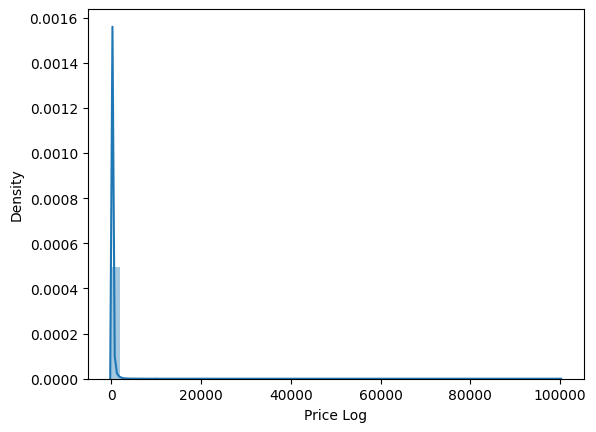

In [98]:
sns.distplot(df_log['price'], axlabel='Price Log');


## Heuristic method to remove outliers:
- A "reasonable" price per night for an Airbnb is subjective, but my method will be to order a list of prices and value counts of listings at each price, and make the cut off above the first price that hundreds of listings have.
Let's see if visualizing `price` based on value counts helps us see a reasonable cut-off:
- If we scroll through the table below, we can observe that the number of listings having each price doesn't reach the 100's until the price of $5,000

In [99]:
DataFrame(df['price'].value_counts()).sort_index(ascending=False)

,price
100000.0,1
99999.0,1
99713.0,1
99110.0,1
99000.0,1
...,...
7.0,1
5.0,2
3.0,1
1.0,1


## Remove listings where `price` > $5,000

In [100]:
df = df.drop(df[df['price'] > 5000].index)

## Visualize Outliers again:
- This looks a lot better.
- There are still outliers, but we'll model based on this data and use those results to inform our conclusion for next steps at the conclusion of this study.

In [101]:
df[['price','accommodates', 'bedrooms', 'beds','minimum_nights', 'maximum_nights']].describe()

,price,accommodates,bedrooms,beds,minimum_nights,maximum_nights
count,274234.000000,274234.000000,204714.000000,271365.000000,274234.000000,274234.000000
mean,243.616347,4.342193,2.040237,2.414976,14.177265,527.409038
std,330.938058,2.973075,1.267867,1.965936,26.374499,454.023121
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,96.000000,2.000000,1.000000,1.000000,2.000000,90.000000
50%,155.000000,4.000000,2.000000,2.000000,3.000000,365.000000
75%,263.000000,6.000000,3.000000,3.000000,30.000000,1125.000000
max,5000.000000,16.000000,50.000000,132.000000,1125.000000,1125.000000


# Check overall number of NULLS in our dataset that now has outliers removed:

### Drop `bedrooms` because of high number of NULLS:
- There are nulls in bedrooms, beds, bathrooms
- The greatest number of nulls occurs in bedrooms, where over 70,000 are missing.
- We'll use a simple imputer for the numeric col nulls


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274234 entries, 0 to 274957
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   description              274234 non-null  object 
 1   neighborhood_overview    274234 non-null  object 
 2   host_about               274234 non-null  object 
 3   host_has_profile_pic     274234 non-null  int64  
 4   host_identity_verified   274234 non-null  int64  
 5   latitude                 274234 non-null  float64
 6   longitude                274234 non-null  float64
 7   property_type            274234 non-null  object 
 8   room_type                274234 non-null  object 
 9   accommodates             274234 non-null  int64  
 10  bedrooms                 204714 non-null  float64
 11  beds                     271365 non-null  float64
 12  price                    274234 non-null  float64
 13  minimum_nights           274234 non-null  int64  
 14  maxi

### Drop Bedrooms

In [103]:
df = df.drop(['bedrooms'], axis=1)

# Does this Data Violate the assumptions of linear regression modeling?

## Multicollinearity
- When two or more predictor variables have a high degree of correlation with one another and do not contribute distinct or independent information to the regression model, this is known as multicollinearity in regression analysis.


### Measure Multicollinearity using Variance Inflation Factor
- We'll measure how much beds, accommodates and bathrooms are correlated with one another.

##### Beds/Accommodates/Bathrooms: Moderately Correlated
- The higher the VIF, the more correlated the variables are to each other. Because the above values are between 1 and 5, it means they are moderately correlated.
- Moderate multicollinearity can be a problem. We'll see if our modeling techniques can address it.

In [144]:
# Adapted from: https://www.statology.org/multicollinearity-in-python/

# Create matrix for regression model using 'beds' as response variable
y, X = dmatrices('beds ~ bathrooms+accommodates', data=df, return_type='dataframe')

# Create df to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns

# Calculate each VIF
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

       variable       VIF
0     Intercept  3.895027
1     bathrooms  1.861159
2  accommodates  1.861159


### Drop Cols that we're not using in analysis:*italicized text*
  - Free text columns we already converted to polarity and subjectivity:
    - `'description', 'neighborhood_overview', 'host_about'`
  - `amenities_keep` (the list of amenities we already transformed to boolean columns

In [104]:
df = df.drop(['description', 'neighborhood_overview', 'host_about', 'amenities_keep'], axis=1)

# Modeling Preparation

## Create df for pipeline:
### Pipelines are used to save code, reduce error, and prevent data leakage.


# Inspect Columns to OHE
- Now we'll create a list of categorical columns by filtering those where the datatype is 'object'
- Then we'll take a random sample of rows where the variable is categorical as a final check that values are clean and look right.

## Categorical Columns:
- Our random sample looks good - so errors detected

In [145]:
## Generate list of categorical columns and print list:
cat_cols = []
for col in range(df.shape[1]):
  if df[df.columns[col]].dtypes == 'object':
    cat_cols.append(df.columns[col])
print("Categorical Columns")
print()

## Print Categorical Columns:
for col in cat_cols:
  print(col)

## Create Dataframe containing categorical columns so we can preview them:
cat_df = df[cat_cols]
print()

# Create a random sample of our categorical features dataframe:
cat_df.apply(lambda cat_df: cat_df.sample(5, random_state=0))

Categorical Columns

property_type
room_type
city
state



,property_type,room_type,city,state
12649,Entire home,Entire homeapt,Hawaii,Hawaii
76695,Entire guesthouse,Entire homeapt,Los Angeles,California
192680,Entire rental unit,Entire homeapt,Nashville,Tennessee
250292,Entire rental unit,Entire homeapt,Seattle,Washington
37900,Entire rental unit,Entire homeapt,Dallas,Texas


In [146]:
# There are no nulls in the categorical columns
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274234 entries, 0 to 274957
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   property_type  274234 non-null  object
 1   room_type      274234 non-null  object
 2   city           274234 non-null  object
 3   state          274234 non-null  object
dtypes: object(4)
memory usage: 10.5+ MB


## Check Unique Values of Categorical Columns:
- **These are only small previews; play around with sorting and paging through the table in Google Colab to see more**

### Property Type

In [147]:
# These look good! Would love to stay in a windmill.
# There are a total of 140 unique values of property type!
DataFrame(df['property_type'].value_counts())

,property_type
Entire rental unit,71547
Entire home,60129
Entire condo,34351
Private room in home,24517
Private room in rental unit,17571
...,...
Riad,1
Private room in bus,1
Shared room in nature lodge,1
Shared room in castle,1


### Room Type

In [148]:
# These look good too. There are only 4 unique values.
DataFrame(df['room_type'].value_counts())

,room_type
Entire homeapt,208095
Private room,62981
Shared room,2366
Hotel room,792


### City

In [149]:
# There are 32 unique cities
DataFrame(df['city'].value_counts())

,city
Los Angeles,44416
New York City,38732
Hawaii,33232
Broward County,17864
Clark County,16463
Austin,14838
San Diego,12485
Nashville,8573
Chicago,8527
Santa Clara County,6843


### There are 20 unique states
- After One-Hot-Encoding, the sum of all the columns generated from these variables in 196, because that's how many unique values they have summed.

In [150]:
# Also cool to observe these "Top 10" states in terms of number of properties
# Go Illinois!!!
DataFrame(df['state'].value_counts())

,state
California,71875
New York,39670
Hawaii,33232
Texas,22263
Florida,17864
Nevada,16463
Tennessee,8573
Illinois,8527
Washington,6818
Louisiana,6778


### Check out NULLS:
- There are 0 nulls in the Categorical Columns

In [151]:
# There are no null values in the boolean columns:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274234 entries, 0 to 274957
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   property_type  274234 non-null  object
 1   room_type      274234 non-null  object
 2   city           274234 non-null  object
 3   state          274234 non-null  object
dtypes: object(4)
memory usage: 10.5+ MB


## Boolean Columns:
- Now we'll do the same thing we did above but for Boolean Columns, creating a list where the `.nunique()` value for each column = 2.

In [152]:
bool_cols = []
for col in range(df.shape[1]):
  nunique_vals = df.iloc[:,col].nunique()
  if nunique_vals == 2:
    bool_cols.append(df.columns[col])
print("Boolean Columns")
print()
for col in bool_cols:
  print(col)
bool_df = df[bool_cols]
print()
bool_df.apply(lambda bool_df: bool_df.sample(5, random_state=0))

Boolean Columns

host_has_profile_pic
host_identity_verified
instant_bookable
license_bool
is_shared_bathroom
air_conditioning
kitchen
wifi
free_park_prem
pets_allowed
pool



,host_has_profile_pic,host_identity_verified,instant_bookable,license_bool,is_shared_bathroom,air_conditioning,kitchen,wifi,free_park_prem,pets_allowed,pool
12649,1,1,1,1,0,0,1,1,0,0,0
76695,1,1,0,1,0,0,1,1,1,0,0
192680,1,1,0,0,0,1,0,1,1,0,0
250292,1,1,0,1,0,1,1,1,0,0,0
37900,1,0,0,0,0,1,1,1,1,0,0


In [153]:
# There are 0 null values in the boolean columns:
df[bool_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274234 entries, 0 to 274957
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   host_has_profile_pic    274234 non-null  int64
 1   host_identity_verified  274234 non-null  int64
 2   instant_bookable        274234 non-null  int64
 3   license_bool            274234 non-null  int64
 4   is_shared_bathroom      274234 non-null  int64
 5   air_conditioning        274234 non-null  int64
 6   kitchen                 274234 non-null  int64
 7   wifi                    274234 non-null  int64
 8   free_park_prem          274234 non-null  int64
 9   pets_allowed            274234 non-null  int64
 10  pool                    274234 non-null  int64
dtypes: int64(11)
memory usage: 25.1 MB


## Numeric Columns (Excluding `price` and `bool_cols`)

In [154]:
num_cols = []
for col in range(df.shape[1]):
  if df[df.columns[col]].dtypes != 'object' and df.columns[col] not in bool_cols:
    num_cols.append(df.columns[col])
num_cols.remove('price')
print("Numeric Columns")
print()
for col in num_cols:
  print(col)
num_df = df[num_cols]
print()
num_df.apply(lambda num_df: num_df.sample(5, random_state=0))

Numeric Columns

latitude
longitude
accommodates
beds
minimum_nights
maximum_nights
bathrooms
desc_polarity
desc_subjectivity
neigh_over_polarity
neigh_over_subjectivity
host_about_polarity
host_about_subjectivity
intercept



,latitude,longitude,accommodates,beds,minimum_nights,maximum_nights,bathrooms,desc_polarity,desc_subjectivity,neigh_over_polarity,neigh_over_subjectivity,host_about_polarity,host_about_subjectivity,intercept
12649,19.09647,-155.75214,4,2.0,3,30,2.0,0.188333,0.428333,0.134292,0.490807,0.231818,0.398653,1
76695,34.10321,-118.27790,2,1.0,3,30,1.0,0.303556,0.546028,0.700000,0.825000,0.546685,0.717396,1
192680,36.14589,-86.81436,4,2.0,1,365,1.0,0.197778,0.435556,0.000000,0.000000,0.458333,0.580508,1
250292,47.62235,-122.32594,2,1.0,30,1125,1.0,0.193409,0.470227,0.000000,0.000000,0.535000,0.826667,1
37900,32.77680,-96.79202,6,3.0,2,45,1.0,0.314762,0.427857,0.533333,0.666667,0.000000,0.000000,1


# Data Pre-Processing and Pipeline and validation metrics set-up

## Add Intercept to Data:
- We can avoid biased residuals if we add an intercept
- https://medium.com/datascienceray/why-add-an-intercept-column-into-datasets-a2385cdb33bc

In [155]:
df['intercept'] = 1

In [156]:
df['intercept'].value_counts()

1    274234
Name: intercept, dtype: int64

## Define Modeling Class ModelWithCV()
- Use this class to execute cross validation with 5 folds on each pipeline and return RMSE, MSE, MAE and R2

In [176]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''

    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()

    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.

        Args:
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)
        '''

        cv_X = X if X else self.X
        cv_y = y if y else self.y

        #10-fold Cross Validation Scores: {self.cv_r2_results}

        # MSE Results:
        self.cv_mse_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring ='neg_mean_squared_error')
        self.cv_mse_mean = np.mean(self.cv_mse_results)
        self.cv_mse_median = np.median(self.cv_mse_results)
        self.cv_mse_std = np.std(self.cv_mse_results)
        #Mean Squared Error: {self.cv_mse_mean*-1} ± {self.cv_mse_std:.5f}

        # MAE Results:
        self.cv_mae_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring ='neg_mean_absolute_error')
        self.cv_mae_mean = np.mean(self.cv_mae_results)
        self.cv_mae_median = np.median(self.cv_mae_results)
        self.cv_mae_std = np.std(self.cv_mae_results)
        #Mean Absolute Error: {self.cv_mae_mean*-1} ± {self.cv_mae_std:.5f}

        # RMSE Results:
        self.cv_rmse_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring ='neg_root_mean_squared_error')
        self.cv_rmse_mean = np.mean(self.cv_rmse_results)
        self.cv_rmse_median = np.median(self.cv_rmse_results)
        self.cv_rmse_std = np.std(self.cv_rmse_results)

        # R2 Results:
        self.cv_r2_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring = 'r2')
        self.cv_r2_mean = np.mean(self.cv_r2_results)
        self.cv_r2_median = np.median(self.cv_r2_results)
        self.cv_r2_std = np.std(self.cv_r2_results)

    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            R-Squared: {self.cv_r2_mean:.5f} ± {self.cv_r2_std:.5f}
            Root Mean Squared Error: {self.cv_rmse_mean*-1} ± {self.cv_rmse_std:.5f}
        ''')
        print(cv_summary)

## Pipeline Set-up

### Boolean features don't need to be scaled
- so we will use 'remainder='passthrough'' To indicate to compiler to let them through pipeline without transformations.

In [158]:
print(cat_cols)

['property_type', 'room_type', 'city', 'state']


In [159]:
print(bool_cols)

['host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'license_bool', 'is_shared_bathroom', 'air_conditioning', 'kitchen', 'wifi', 'free_park_prem', 'pets_allowed', 'pool']


In [160]:
print(num_cols)

['latitude', 'longitude', 'accommodates', 'beds', 'minimum_nights', 'maximum_nights', 'bathrooms', 'desc_polarity', 'desc_subjectivity', 'neigh_over_polarity', 'neigh_over_subjectivity', 'host_about_polarity', 'host_about_subjectivity', 'intercept']


### Pipeline for numerics:
- We need to scale our numeric values because we're going to use

In [161]:
# Pipeline for numerics (SCALE data):
numpipe = Pipeline([
    ('stan_scale', StandardScaler()),
    ('num_impute', SimpleImputer(strategy='median'))
])


### Pipeline for Categoricals:

In [162]:
# Pipeline for categorical feature (One-Hot-Encode):
catpipe = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')) # Using handle_unknown param en lieu of stratify during train-test-split
])

### We now have our numeric and categorical pipelines.
- Since we don't have any nulls, and binary features don't need to be transformed or one-hot-encoded,
- Our binary features don't need any transformations, so we will use `remainder='passthrough'` to let them through.
- Next step is to handle columns holistically with `ColumnTransformer`

### Create Column Transformer for Pipeline

In [163]:
# We will use our pipeline objects as transformer argument for ColumnTransformer
# our transformer is a tuple and includes a `columns` argument

ColTrans = ColumnTransformer(transformers=[
    ('numerics', numpipe, num_cols),
    ('categoricals', catpipe, cat_cols)
], remainder='passthrough')

## Train Test Split
- The advantages of creating 2 splits is the hold-out testing set that's kept pristine until we train and test our final model.

### First Split

In [164]:
# Create X (predictors) and y (target) variables:
X_1 = df.drop('price', axis=1)
y_1 = df['price']

# Split Data into train and test:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, random_state=666)

### Second Split

In [165]:
# Split Data into train and test:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_1_train, y_1_train, random_state=666)


# Model #1: Baseline Dummy
- We run a baseline as it "can only get better from here"
- Any subsequent model must have better results than this one to justify using as our next step.

In [166]:
# Create Dummy Model Pipeline
# Using median as the strategy because it's less sensitive to outliers
dumpipe = Pipeline([
    ('ct', ColTrans),
    ('dummy', DummyRegressor(strategy='median'))
])

In [167]:
# Fit the dummy regressor to the training data:
dumpipe.fit(X_2_train, y_2_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('stan_scale',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['latitude', 'longitude',
                                                   'accommodates', 'beds',
                                                   'minimum_nights',
                                                   'maximum_nights',
                                                   'bathrooms', 'desc_polarity',
                                                   'desc_subjectivity',
                                                   'neigh_over_polarity',
                                                   'neigh_over_subjectivity',
                                                   'host_about_polarity',
                                                   'host_about_subjectivity',
                                                   'intercept']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['property_type', 'room_type',
                                                   'city', 'state'])])),
                ('dummy', DummyRegressor(strategy='median'))])

## Dummy Regressor Cross validation on Training Data
- Cross-validate using the class we defined previously.
- We're using the data from our second split --- X_1_train and y_2_train won't be used until we evaluate our final model.

In [177]:
# Now let's instantiate a dummy pipeline model and fit via inheritance from the ModelWithCV class:
dum_pipe_cv = ModelWithCV(
    dumpipe,
    model_name='dummy',
    X=X_2_train,
    y=y_2_train,
)

In [178]:
# These are incredibly bad results, as the R-Squared value is negative.
dum_pipe_cv.print_cv_summary()

CV Results for `dummy` model:
            R-Squared: -0.07173 ± 0.00201
            Root Mean Squared Error: 343.8260072900272 ± 3.50138
        


## Compare Cross-Validated Result using Train data on Test Data:
- Adapted from: https://gnpalencia.org/optbinning/tutorials/tutorial_binning_process_sklearn_pipeline.html

In [179]:
# It doesn't look like we have anything to suggest overfitting,
# Because our R2 scores are just junk.
# our error is interestingly low -- being off by $338 isn't horrific although
# It's definitely not good.
y_1_test_pred_dumpipe = dumpipe.predict(X_1_test)

print("R2 score: {:.5f}".format(r2_score(y_1_test, y_1_test_pred_dumpipe)))
print("RMSE:      {:.5f}".format(mean_squared_error(y_1_test, y_1_test_pred_dumpipe, squared=False)))


R2 score: -0.07196
RMSE:      338.47696


# Model #2: Lasso ("At least R2 isn't negative") Regression
- I now move on to use my first "real" model. I used Ridge and Lasso regression because they were the best performing models in a study I used to inspire my modeling strategies: [A Sustainable Price Prediction Model for Airbnb Listings](https://www.researchgate.net/publication/373625586_A_Sustainable_Price_Prediction_Model_for_Airbnb_Listings_Using_Machine_Learning_and_Sentiment_Analysis)
- I tried Lasso first because it was the best performing out of the two in the study.
- Another reason I used Ridge and Lasso regression models was because they make use of regularization strategies to mitigate multicollinearity's negative impact on the model's quality and validity of conclusions. Both Aim for Optimal Importance but Ridge Regression also prevents coefficients with extreme values while Lasso Regression eliminates any unnecessary coefficients

In [171]:
# Create Lasso Model Pipeline
lassopipe = Pipeline([
    ('ct', ColTrans),
    ('lasso', Lasso())
])

In [172]:
# Fit to training data
lassopipe.fit(X_2_train, y_2_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('stan_scale',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['latitude', 'longitude',
                                                   'accommodates', 'beds',
                                                   'minimum_nights',
                                                   'maximum_nights',
                                                   'bathrooms', 'desc_polarity',
                                                   'desc_subjectivity',
                                                   'neigh_over_polarity',
                                                   'neigh_over_subjectivity',
                                                   'host_about_polarity',
                                                   'host_about_subjectivity',
                                                   'intercept']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['property_type', 'room_type',
                                                   'city', 'state'])])),
                ('lasso', Lasso())])

In [180]:
# Instantiate Lasso pipeline model and fit via inheritance from the ModelWithCV class:
lassopipe_cv = ModelWithCV(
    lassopipe,
    model_name='lasso',
    X=X_2_train,
    y=y_2_train,
)

In [181]:
# Print results from cross-validation on training data
lassopipe_cv.print_cv_summary()

CV Results for `lasso` model:
            R-Squared: 0.34361 ± 0.00757
            Root Mean Squared Error: 269.0708187235658 ± 2.97901
        


#### Compare to Previous Cross-Val Results
- We've improved a LOT!
- Our R-Squared value improved drastically so that now we think our data explains 34% of variability in price rather than a negative amount which isn't even possible.
- Our RMSE has also dropped meaning we can expect to be about $269 off of the correct price rather than $343

#### Results:
CV Results for `dummy` model:
- R-Squared: -0.07173 ± 0.00201
- Root Mean Squared Error: 343.8260072900272 ± 3.50138

## Lasso Regressor Results on Test Data:
- The values are very similar between train and test, similarly bad.

In [187]:
test_pred_lassopipe = lassopipe.predict(X_2_test)

print("R2 score: {:.5f}".format(r2_score(y_2_test, test_pred_lassopipe)))
print("RMSE:      {:.5f}".format(mean_squared_error(y_2_test, test_pred_lassopipe, squared=False)))


R2 score: 0.34819
RMSE:      268.55985


#### Compare to Dummy Regressor Results on Test:
- R2 score: -0.07196
- RMSE:      338.47696

# Model #3: RidgeRegression

In [188]:
# Create Ridge Model Pipeline
ridgepipe = Pipeline([
    ('ct', ColTrans),
    ('ridge', Ridge())
])

In [189]:
ridgepipe.fit(X_2_train, y_2_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('stan_scale',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['latitude', 'longitude',
                                                   'accommodates', 'beds',
                                                   'minimum_nights',
                                                   'maximum_nights',
                                                   'bathrooms', 'desc_polarity',
                                                   'desc_subjectivity',
                                                   'neigh_over_polarity',
                                                   'neigh_over_subjectivity',
                                                   'host_about_polarity',
                                                   'host_about_subjectivity',
                                                   'intercept']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['property_type', 'room_type',
                                                   'city', 'state'])])),
                ('ridge', Ridge())])

In [190]:
ridgepipe_cv = ModelWithCV(
    ridgepipe,
    model_name='ridge',
    X=X_2_train,
    y=y_2_train,
)

In [191]:
ridgepipe_cv.print_cv_summary()

CV Results for `ridge` model:
            R-Squared: 0.36288 ± 0.00595
            Root Mean Squared Error: 265.0911366423387 ± 2.43114
        


#### Compare to Lasso CV Results:
- We've improved a tiny bit, from .34 with lasso to .36 with ridge.
- However our RMSE has slightly increased
- We may decide we want to proceed with Lasso, but let's check the testing data validation results.

- CV Results for `lasso` model:
  - R-Squared: 0.34361 ± 0.00757
  - Root Mean Squared Error: 269.0708187235658 ± 2.97901

## *Ridge* Regressor Results on Test Data:
- Adapted from: https://gnpalencia.org/optbinning/tutorials/tutorial_binning_process_sklearn_pipeline.html

In [192]:
test_pred_ridgepipe = ridgepipe.predict(X_2_test)

print("R2 score: {:.5f}".format(r2_score(y_2_test, test_pred_ridgepipe)))
print("RMSE:      {:.5f}".format(mean_squared_error(y_2_test, test_pred_ridgepipe, squared=False)))

R2 score: 0.36488
RMSE:      265.09983


## Compare to Lasso Results on Test Data:
- R2 score: 0.34819
- RMSE:      268.55985

## Comments - Comparing Lasso and Ridge
- Because our R2 score increased and error only increased a little between Lasoo and Ridge, we'll go with Ridge for our next step.
- When comparing train and test for Ridge, there isn't much overfitting.

# Final Model: Grid-Searched Ridge Regression
- Now we'll tune some hyperparameters to see if we can improve our results by finding the optimal combination of alpha and solver

## Print Available Hyper-parameters for Ridge Regression:

In [193]:
# Print all of my ridge() object's hyperparameters:
for key in ridgepipe.get_params().keys():
    if key.startswith('ridge__'):
        print(key)

ridge__alpha
ridge__copy_X
ridge__fit_intercept
ridge__max_iter
ridge__positive
ridge__random_state
ridge__solver
ridge__tol


In [194]:
# I decided on the values for this search space by studying documentation
ridge_search_space = {'ridge__alpha':[.5, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40],
                      'ridge__solver':['auto', 'svd', 'lsqr', 'sparse_output', 'saga']
                      }

In [195]:
ridge_grid_search = GridSearchCV(ridgepipe, ridge_search_space, n_jobs=-1, cv=5, return_train_score=True)

In [196]:
#!pip install ipython-autotime
#%load_ext autotime

In [197]:
import time, psutil
uptime = time.time() - psutil.boot_time()
remain = 12*60*60 - uptime

In [198]:
%%time
ridge_grid_search.fit(X_2_train,y_2_train)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [171]:
print('Best Hyperparameters: %s' % ridge_grid_search.best_params_)

## Use best alpha to evaluate

In [199]:
# Create Ridge Model with Best HyperParameters Pipeline
# Best Hyperparameters: {'ridge__alpha': 10, 'ridge__solver': 'svd'}

ridge_grid_use_best_alpha = Pipeline([
    ('ct', ColTrans),
    ('ridge', Ridge(alpha=10, solver='svd'))
])

In [201]:
# Because this is our last model, this time we'll fit to the training data from
# Our first split
ridge_grid_use_best_alpha.fit(X_1_train, y_1_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('stan_scale',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['latitude', 'longitude',
                                                   'accommodates', 'beds',
                                                   'minimum_nights',
                                                   'maximum_nights',
                                                   'bathrooms', 'desc_polarity',
                                                   'desc_subjectivity',
                                                   'neigh_over_polarity',
                                                   'neigh_over_subjectivity',
                                                   'host_about_polarity',
                                                   'host_about_subjectivity',
                                                   'intercept']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['property_type', 'room_type',
                                                   'city', 'state'])])),
                ('ridge', Ridge(alpha=10, solver='svd'))])

In [202]:
# Cross-validate using training data from first split
ridge_grid_use_best_alpha_cv = ModelWithCV(
    ridge_grid_use_best_alpha,
    model_name='ridge grid best alpha',
    X=X_1_train,
    y=y_1_train,
)

In [203]:
ridge_grid_use_best_alpha_cv.print_cv_summary()

CV Results for `ridge grid best alpha` model:
            R-Squared: 0.36291 ± 0.00841
            Root Mean Squared Error: 265.1687596568819 ± 6.02849
        


Compare CV Results for `ridge` model:
- **We haven't improved by much but we have by a little by tuning hyperparameters**

- CV Results for `ridge` model:
  - R-Squared: 0.36288 ± 0.00595
  - Root Mean Squared Error: 265.0911366423387 ± 2.43114

In [204]:
# We can see from this because the training R2 score is slightly higher
# than our testing score, it may be considered slightly overfit
y_1_test_pred_ridge_grid_use_best_alpha = ridge_grid_use_best_alpha.predict(X_1_test)

print("R2 score: {:.5f}".format(r2_score(y_1_test, y_1_test_pred_ridge_grid_use_best_alpha)))

R2 score: 0.37517


# Final Evaluation
- Here, we evaluate our final model on the first train-test-split

In [207]:
# Create Ridge Model with Best HyperParameters Pipeline
# Best Hyperparameters: {'ridge__alpha': 10, 'ridge__solver': 'svd'}

final_pipe = Pipeline([
    ('ct', ColTrans),
    ('ridge', Ridge(alpha=10, solver='svd'))
])

In [208]:
final_pipe.fit(X_1_train, y_1_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('stan_scale',
                                                                   StandardScaler()),
                                                                  ('num_impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['latitude', 'longitude',
                                                   'accommodates', 'beds',
                                                   'minimum_nights',
                                                   'maximum_nights',
                                                   'bathrooms', 'desc_polarity',
                                                   'desc_subjectivity',
                                                   'neigh_over_polarity',
                                                   'neigh_over_subjectivity',
                                                   'host_about_polarity',
                                                   'host_about_subjectivity',
                                                   'intercept']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['property_type', 'room_type',
                                                   'city', 'state'])])),
                ('ridge', Ridge(alpha=10, solver='svd'))])

In [211]:
final_pipe_cv = ModelWithCV(
    ridge_grid_use_best_alpha,
    model_name='final model',
    X=X_1_train,
    y=y_1_train,
)

In [212]:
final_pipe_cv.print_cv_summary()

CV Results for `final model` model:
            R-Squared: 0.36291 ± 0.00841
            Root Mean Squared Error: 265.1687596568819 ± 6.02849
        


## Final Model Test Results on Hold-Out Data

In [213]:
final_model_pred = final_pipe.predict(X_1_test)

print("R2 score: {:.5f}".format(r2_score(y_1_test, final_model_pred)))
print("RMSE:      {:.5f}".format(mean_squared_error(y_1_test, final_model_pred, squared=False)))

R2 score: 0.37517
RMSE:      258.41649


# Fit Final Model on All Data

In [ ]:
final_pipe_train_all = Pipeline([
    ('ct', ColTrans),
    ('ridge', Ridge(alpha=10, solver='svd'))
])

In [ ]:
final_pipe_train_all.fit(X, y)

# Results:
### Discussion:
- I was able to reduce the distance between my predicted results and the real price (RMSE) with each successive model. I was also able to increase how much variability in my target value is explained by my data (R2). However, my results are still sub-par. My final R-Squared value of .38 means that 62% of the variation in price is explained by data that is NOT in my dataset. Only 32% of the variability in price is explained by my available data.
- I won't discount the success of seeing that Ridge Regression performed a bit better than Lasso Regression - R2 was improved by about 3%, and error was reduced by about 1%. My final model improved from Lasso Regression by 8% for R2 value and there was a 4% reduction in the RMSE value.

### Results from each Model Iteration:
- Lasso Regression:
  - RMSE: 268
  - R-Squared: 0.35
- Ridge Regression:
  - RMSE: 265
  - R-Squared: 0.36
- Final Model, Ridge Regression with hyperparameters tuned:
  - Optimized Hyperparameters via GridSearchCV:
    - alpha=10
    - solver=svd
  - RMSE: 258
  - R-Squared: 0.38


# Conclusion:
1. My model’s performance was drastically lower compared to studies I consulted.
   - The study's superior model performance indicates that there is something wrong with my feature selection (missing review data) -- which would have to change my business problem.
2. There weren’t great gains in model performance were achieved: Lasso->Ridge->Tuned Ridge


# Recommendations and Next Steps:
1. Tweak Approach to Problem:
   - Which features are most important for highest priced listings?
   - Subset by attributes listers can’t change like location and property type.
   - Different models for each city or region.
2. More Data:
   - Review Data
   - Additional Amenities
3. Use Spatial Auto-correlation for lat/long values